In [1]:
# SET THIS VARIABLE IF 
explained_model_backend = 'tensorflow' # 'sklearn' or 'tensorflow'

# WARNING REMEMEBER TO CHANGE MANUALLY CFEC MODEL LOADING IF SOME CHANGES APPEAR 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
from utils.transformations import min_max_normalization, inverse_min_max_normalization, transform_to_sparse, inverse_transform_to_sparse
import warnings
import tensorflow as tf
import pickle

warnings.filterwarnings('ignore', category=UserWarning) #Ignore sklearn "RF fitted with FeatureNames"

train_dataset = pd.read_csv("../data/adult.csv")
dataset_name = 'adult'
instance_to_explain_index = 890

with open('../data/adult_constraints.json', 'r') as f:
    constr = json.load(f)

if explained_model_backend == 'sklearn':
    # SKLEARN
    with open('../models/adult_RF.pkl', 'rb') as f:
        explained_model = pickle.load(f)
else: 
    # TENSORFLOW
    explained_model = tf.keras.models.load_model('../models/adult_NN/')


train_dataset = train_dataset[constr['features_order_nonsplit']]
train_dataset.columns

Index(['hours.per.week', 'age', 'capital.loss', 'education.num',
       'capital.gain', 'workclass', 'marital.status', 'occupation', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')

In [3]:
actionable_mask_indices_sparse = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

In [4]:
query_instance = train_dataset.drop(columns="income")[instance_to_explain_index:instance_to_explain_index+1]

all_counterfactuals = pd.DataFrame(columns=train_dataset.columns.tolist() + ['explainer'])

In [5]:
query_instance

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country
890,40,35,1887,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States


In [6]:
# Transform dataset to sparse
train_dataset_sparse = transform_to_sparse(
    _df=train_dataset.drop(columns="income"),
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Min-max normalization
train_dataset_sparse_normalized = min_max_normalization(
    _df=train_dataset_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

query_instance_sparse_normalized = train_dataset_sparse_normalized[instance_to_explain_index:instance_to_explain_index+1]

In [7]:
explained_model.predict(query_instance_sparse_normalized)

1/1 [==============================] - 0s 116ms/step


array([[2.2027573e-04, 9.9977976e-01]], dtype=float32)

DICE

In [8]:
from dice import DiceModel

if explained_model_backend == 'sklearn':
    dice_model = DiceModel(
        train_dataset=train_dataset,
        continuous_features=constr['continuous_features_nonsplit'],
        categorical_features=constr['categorical_features_nonsplit'],
        target=constr['target_feature'],
        model_path='../models/adult_RF.pkl',
        backend='sklearn',
        func='ohe-min-max',
    )
else:
    dice_model = DiceModel(
        train_dataset=train_dataset,
        continuous_features=constr['continuous_features_nonsplit'],
        categorical_features=constr['categorical_features_nonsplit'],
        target=constr['target_feature'],
        model_path='../models/adult_NN/',
        backend='TF2',
        func='ohe-min-max',
    )

dice_counterfactuals_df = dice_model.generate_counterfactuals(
    query_instance=query_instance,
    total_CFs=50,
    desired_class='opposite',
    features_to_vary=constr['actionable_features'],
    permitted_range=constr['feature_ranges'],
)

dice_counterfactuals_df['explainer'] = 'dice'
all_counterfactuals = pd.concat([all_counterfactuals, dice_counterfactuals_df], ignore_index=True)

100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


In [9]:
all_counterfactuals.head(8)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,40.0,17.0,1887.0,14.0,33318.0,State-gov,Married-spouse-absent,Prof-specialty,White,Male,United-States,0,dice
1,40.0,17.0,2580.0,14.0,0.0,Local-gov,Never-married,Machine-op-inspct,White,Male,United-States,0,dice
2,40.0,35.0,1623.0,1.0,0.0,Local-gov,Widowed,Priv-house-serv,White,Male,United-States,0,dice
3,40.0,19.0,1887.0,6.0,85934.0,Local-gov,Separated,Prof-specialty,White,Male,United-States,0,dice
4,40.0,26.0,1887.0,14.0,0.0,Never-worked,Widowed,Prof-specialty,White,Male,United-States,0,dice
5,40.0,17.0,1887.0,14.0,0.0,State-gov,Married-spouse-absent,Prof-specialty,White,Male,United-States,0,dice
6,35.0,22.0,1887.0,6.0,11039.0,?,Married-civ-spouse,Prof-specialty,White,Male,United-States,0,dice
7,40.0,35.0,760.0,2.0,73708.0,Local-gov,Widowed,Priv-house-serv,White,Male,United-States,0,dice


In [10]:
print(np.where(actionable_mask_indices_sparse)[0].tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


CFEC

In [11]:
from cfec_ece import CfecEceModel 

train_dataset_sparse_normalized_subsample = train_dataset_sparse_normalized.sample(frac=1.0)

if explained_model_backend == 'sklearn':
    cfec_model = CfecEceModel(
        train_data_normalized=train_dataset_sparse_normalized_subsample,
        constraints_dictionary=constr,
        model_path='../models/adult_RF.pkl',
        model_backend='sklearn',
        fimap_load_s_g_full_id=f'adult_sklearn|2023-01-17',
        #fimap_save_s_q_prefix='adult_sklearn',
        columns_to_change=np.where(actionable_mask_indices_sparse)[0].tolist(),
        )
else:
    cfec_model = CfecEceModel(
        train_data_normalized=train_dataset_sparse_normalized_subsample,
        constraints_dictionary=constr,
        model_path='../models/adult_NN/',
        model_backend='tensorflow',
        fimap_load_s_g_full_id=f'adult_tensorflow|2023-01-17',
        #fimap_save_s_q_prefix='adult_tensorflow',
        columns_to_change=np.where(actionable_mask_indices_sparse)[0].tolist(),
        )

Constraints: 
 [Freeze(columns=['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White']), Freeze(columns=['sex_Female', 'sex_Male']), Freeze(columns=['native.country_?', 'native.country_Cambodia', 'native.country_Canada', 'native.country_China', 'native.country_Columbia', 'native.country_Cuba', 'native.country_Dominican-Republic', 'native.country_Ecuador', 'native.country_El-Salvador', 'native.country_England', 'native.country_France', 'native.country_Germany', 'native.country_Greece', 'native.country_Guatemala', 'native.country_Haiti', 'native.country_Holand-Netherlands', 'native.country_Honduras', 'native.country_Hong', 'native.country_Hungary', 'native.country_India', 'native.country_Iran', 'native.country_Ireland', 'native.country_Italy', 'native.country_Jamaica', 'native.country_Japan', 'native.country_Laos', 'native.country_Mexico', 'native.country_Nicaragua', 'native.country_Outlying-US(Guam-USVI-etc)', 'native.country_Peru', 'native.count

In [12]:
cfec_counterfactuals_raw, list_cfs_explainers = cfec_model.generate_counterfactuals(query_instance=query_instance_sparse_normalized.iloc[0])
cfec_counterfactuals_raw

BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x00000231215C61D0> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x0000023125F2B580> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x00000231273B63B0> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000002310880C580> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000002312869F0D0> generated 1 counterfactuals
1/1 [==============================] - 0s 21ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000002311FE2D120> generated 1 counterfactuals
1/1 [==============================] - 0s 21ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x0000023125F16AA0> generated 1 counterfactuals
1/1 [==============================] - 0s 25ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x0000023125F177F0> generated 1 counterfactuals
1/1 

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.198023,0.046586,0.233363,0.866667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
1,0.204389,0.052753,0.240047,0.866667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
2,0.205644,0.054043,0.241396,0.866667,-0.186067,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
3,0.207140,0.056778,0.248038,0.866667,-0.186254,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
4,0.219793,0.068438,0.256649,0.866667,-0.183813,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
5,0.220085,0.068939,0.257149,0.866667,-0.183642,0.181907,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
6,0.256363,0.104585,0.291992,0.720117,-0.144402,0.144335,0.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
7,0.377410,-0.121381,0.429075,0.844281,-0.007838,-0.008860,0.029483,0.064279,0.000215,0.697030,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
8,0.377719,-0.117895,0.428160,0.844017,-0.005895,-0.007936,0.029483,0.064279,0.000215,0.697030,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
9,0.385857,0.010506,0.430735,0.852856,-0.004270,0.001861,0.029483,0.064279,0.000215,1.156572,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11


In [13]:
# Do not allow for negative values
cfec_counterfactuals_raw[cfec_counterfactuals_raw < 0] = 0

# Inverse min-max normalization
cfec_counterfactuals = inverse_min_max_normalization(
    _df=cfec_counterfactuals_raw,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
cfec_counterfactuals = inverse_transform_to_sparse(
    sparse_df=cfec_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


In [14]:
list_cfs_explainers = list(map(lambda x: 'Cadex' if 'Cadex' in x else 'Fimap', list_cfs_explainers))
cfec_counterfactuals['explainer'] = list_cfs_explainers
all_counterfactuals = pd.concat([all_counterfactuals, cfec_counterfactuals], ignore_index=True)
cfec_counterfactuals

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,20,20,1016,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
1,21,20,1045,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
2,21,20,1051,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
3,21,21,1080,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
4,22,21,1117,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
5,22,22,1120,14,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
6,26,24,1271,11,0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cadex
7,37,17,1869,13,0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,Fimap
8,38,17,1865,13,0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,Fimap
9,38,17,1876,13,0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,Fimap


In [15]:
query_instance_sparse_normalized[cfec_counterfactuals_raw.columns[39:]]

,race_Other,race_White,sex_Female,sex_Male,native.country_?,native.country_Cambodia,native.country_Canada,native.country_China,native.country_Columbia,native.country_Cuba,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
890,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
cfec_counterfactuals_raw[cfec_counterfactuals_raw.columns[39:]]

,race_Other,race_White,sex_Female,sex_Male,native.country_?,native.country_Cambodia,native.country_Canada,native.country_China,native.country_Columbia,native.country_Cuba,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
1,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
2,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
3,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
4,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
5,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
6,0.000000e+00,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0
7,1.298469e-10,1.0,0.0,1.0,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0
8,1.298469e-10,1.0,0.0,1.0,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0
9,1.298469e-10,1.0,0.0,1.0,7.982684e-10,6.132937e-12,4.038956e-11,0.0,4.754096e-11,3.583714e-11,...,2.851869e-12,0.0,0.0,0.0,9.338692e-12,0.0,6.132937e-12,1.0,0.0,0.0


WACHTER

In [17]:
feature_ranges = (
    train_dataset_sparse_normalized.to_numpy().min(axis=0),
    train_dataset_sparse_normalized.to_numpy().max(axis=0),
)
non_actionable_indices = ~np.array(actionable_mask_indices_sparse, dtype='bool')
feature_ranges[0][non_actionable_indices] = query_instance_sparse_normalized.to_numpy()[0][non_actionable_indices]
feature_ranges[1][non_actionable_indices] = query_instance_sparse_normalized.to_numpy()[0][non_actionable_indices]
feature_ranges

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

In [18]:
from alibi_impl import AlibiWachter

continous = len(constr['continuous_features_nonsplit'])




if explained_model_backend == 'sklearn':
    max_iter = 100
    max_lam_steps=10
    lam_init=0.001
    lr_init=0.1
    early_stop=50
    tolerance=0.4
    target_proba=1.0

    wachter_model = AlibiWachter('../models/adult_RF.pkl', 'sklearn', 
    query_instance_sparse_normalized.shape, feature_ranges=feature_ranges,
    max_iter=max_iter, max_lam_steps=max_lam_steps, lam_init=lam_init, 
    learning_rate_init=lr_init, early_stop=early_stop, tolerance=tolerance,
    target_proba=target_proba,
    )
else:
    #eps_wachter = np.array([[0.01] * continous + [0.01] * (len(train_dataset_sparse_normalized.columns) - continous)]) * (np.array(actionable_mask_indices_sparse, dtype=int) + 0.001)
    wachter_model = AlibiWachter('../models/adult_NN/', 'tensorflow', query_instance_sparse_normalized.shape, target_proba=1.0, feature_ranges=feature_ranges)
    
explanation = wachter_model.generate_counterfactuals(query_instance_sparse_normalized)

c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
explanation.cf['X']

array([[0.09349661, 0.        , 0.23572376, 0.73881024, 0.        ,
        0.01840599, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.20586866,
        0.        , 1.        , 0.10298693, 0.16512059, 0.15501033,
        0.13461186, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.11042768, 0.        , 0.        , 0.02433156,
        0.2649583 , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [20]:
explanation.cf['class']

0

In [21]:
wachter_counterfactuals = [explanation.cf['X']]
for key, lst in explanation['data']['all'].items():
    if lst:
        for cf in lst:
            wachter_counterfactuals.append(cf['X'])

wachter_counterfactuals = np.array(wachter_counterfactuals).reshape(-1, query_instance_sparse_normalized.shape[1])

wachter_counterfactuals_df = pd.DataFrame(wachter_counterfactuals, columns=constr['features_order_after_split'])

# Inverse min-max normalization
wachter_counterfactuals_df = inverse_min_max_normalization(
    _df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
wachter_counterfactuals_df = inverse_transform_to_sparse(
    sparse_df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

wachter_counterfactuals_df['explainer'] = 'wachter'

# Reduce number of Wachter counterfactuals because they are almost the same
sampled_wachter_cfs = wachter_counterfactuals_df.sample(min(len(wachter_counterfactuals_df), 10))

#sampled_wachter_cfs = sampled_wachter_cfs.append(wachter_counterfactuals_df.iloc[0])

all_counterfactuals = pd.concat([all_counterfactuals, wachter_counterfactuals_df.iloc[0:1], sampled_wachter_cfs], ignore_index=True)

wachter_counterfactuals_df.head(11)

C:\Users\ignacy\AppData\Local\Temp\ipykernel_5524\2026911664.py:2: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  for key, lst in explanation['data']['all'].items():
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,24,70,0,1,9349,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
1,26,67,313,1,22348,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
2,21,63,65,1,17042,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
3,17,61,0,1,13102,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
4,15,59,0,1,10150,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
5,13,59,0,1,7964,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
6,12,58,0,1,6401,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
7,12,58,0,1,5358,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
8,12,59,0,1,4760,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter
9,13,60,0,1,4550,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter


In [22]:
wachter_counterfactuals_df.iloc[0:1]

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,24,70,0,1,9349,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,wachter


In [23]:
wachter_counterfactuals_df.shape

(18, 12)

CEM

In [24]:
from alibi.explainers import CEM

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution()

if explained_model_backend == 'sklearn':
    # SKLEARN
    with open('../models/adult_RF.pkl', 'rb') as f:
        explained_model = pickle.load(f)
else: 
    # TENSORFLOW
    explained_model = tf.keras.models.load_model('../models/adult_NN/')

shape = query_instance_sparse_normalized.shape  # instance shape
continous = len(constr['continuous_features_nonsplit'])
clip = (-1000.,1000.)
eps_cem = (
        0.05,
        np.array([[0.05] * continous + [1.0] * (len(train_dataset_sparse_normalized.columns) - continous)]) #* (np.array(actionable_mask_indices_sparse) + 0.001) # Dont allow changes on non-actionable features
        )
# eps_cem = (0.1, 0.1)

if explained_model_backend == 'sklearn':
    mode = 'PN'
    #feature_range = (train_dataset_sparse_normalized.to_numpy().min(),  # feature range for the perturbed instance
    #                   train_dataset_sparse_normalized.to_numpy().max()) 
    update_num_grad = 2
    c_init = 15.  # initial weight c of the loss term encouraging to predict a different class (PN) or
                # the same class (PP) for the perturbed instance compared to the original instance to be explained
    # Return probabilities for x
    cem_pred_fn = lambda x: np.array(explained_model.predict_proba(x)[0])#explained_model.predict_proba(x)[0][0][::-1].reshape(1, 2)#np.array([explained_model.predict_proba(x)[0][0][1], explained_model.predict_proba(x)[0][0][0]])

    cem = CEM(cem_pred_fn, mode, shape, kappa=0.0, beta=0.1, feature_range=feature_ranges, 
            update_num_grad=update_num_grad, clip=clip, no_info_val=-0.0, c_init=c_init,
            c_steps=10, learning_rate_init=.1, max_iterations=10, eps=eps_cem
            )
else:
    mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
    kappa = .3 # minimum difference needed between the prediction probability for the perturbed instance on the
                # class predicted by the original instance and the max probability on the other classes
                # in order for the first loss term to be minimized
    beta = .1  # weight of the L1 loss term
    c_init = 10  # initial weight c of the loss term encouraging to predict a different class (PN) or
                # the same class (PP) for the perturbed instance compared to the original instance to be explained
   
    c_steps = 10  # nb of updates for c
    max_iterations = 1000  # nb of iterations per value of c
    # feature_range = (train_dataset_sparse_normalized.to_numpy().min(axis=0).reshape(shape),  # feature range for the perturbed instance
    #                 train_dataset_sparse_normalized.to_numpy().max(axis=0).reshape(shape))  # can be either a float or array of shape (1xfeatures)
    #feature_range = (train_dataset_sparse_normalized.to_numpy().min(),train_dataset_sparse_normalized.to_numpy().max())  # can be either a float or array of shape (1xfeatures)
      # gradient clipping
    lr_init = 1e-2  # initial learning rate

    # initialize CEM explainer and explain instance
    cem = CEM(explained_model, mode, shape, kappa=kappa, beta=beta, feature_range=feature_ranges,
            max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
            learning_rate_init=lr_init, clip=clip, no_info_val=0.0
            )

In [25]:

cem.fit(train_dataset_sparse_normalized.to_numpy(), no_info_type='median')  # we need to define what feature values contain the least
                                                                    # info wrt predictions
                                                                    # here we will naively assume that the feature-wise median
                                                                    # contains no info; domain knowledge helps!

"no_info_type" variable already defined. Previous values will be overwritten.


CEM(meta={
  'name': 'CEM',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'mode': 'PN',
              'shape': (1, 85),
              'kappa': 0.3,
              'beta': 0.1,
              'feature_range': (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [26]:
cem_explanation = cem.explain(query_instance_sparse_normalized.to_numpy(), verbose=True)

cem_cf_df = pd.DataFrame(cem_explanation.PN, columns=constr['features_order_after_split'])

# Inverse min-max normalization
cem_cf_df = inverse_min_max_normalization(
    _df=cem_cf_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
cem_cf_df = inverse_transform_to_sparse(
    sparse_df=cem_cf_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

cem_cf_df['explainer'] = 'Cem'
print(all_counterfactuals.shape)
all_counterfactuals = pd.concat([all_counterfactuals, cem_cf_df], ignore_index=True)
print(all_counterfactuals.shape)

cem_cf_df


Iteration: 0; Const: 10.0
Loss total: 12.996, loss attack: 12.996
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 1.00, max non target proba: 0.00
Gradient graph min/max: -0.014/0.154
Gradient graph mean/abs mean: -0.001/0.006

Iteration: 100; Const: 10.0
Loss total: 12.996, loss attack: 12.996
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 1.00, max non target proba: 0.00
Gradient graph min/max: -0.014/0.154
Gradient graph mean/abs mean: -0.001/0.006

Iteration: 200; Const: 10.0
Loss total: 12.996, loss attack: 12.996
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 1.00, max non target proba: 0.00
Gradient graph min/max: -0.014/0.154
Gradient graph mean/abs mean: -0.001/0.006

Iteration: 300; Const: 10.0
Loss total: 12.996, loss attack: 12.996
L2: 0.000, L1: 0.000, loss AE: 0.000
Target proba: 1.00, max non target proba: 0.00
Gradient graph min/max: -0.014/0.154
Gradient graph mean/abs mean: -0.001/0.006

Iteration: 400; Const: 10.0
Loss total: 12.996, loss attack: 12.996
L

d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,43,80,27,1,39795,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,Cem


CFPROTO

In [27]:
# from alibi.explainers import CounterfactualProto

# import pickle
# with open('../models/adult_RF.pkl', 'rb') as f:
#     cfprot_model = pickle.load(f)
# predict_fnct = lambda x: cfprot_model.predict(x)


In [28]:
# cat_vars_ord = {}
# for i, cat in enumerate(constr['categorical_features_nonsplit']):
#     start_index = np.argwhere(cat == train_dataset.columns.to_numpy())[0][0]
#     unique = len(np.unique(train_dataset[cat]))
#     cat_vars_ord[start_index] = unique
# print(cat_vars_ord)

In [29]:
# cat_vars_ohe = {}
# for f in constr['categorical_features_nonsplit']:
#     indx = constr['feature_first_occurrence_after_split'][f]
#     cnt = constr['features_count_nonsplit'][f] 
#     cat_vars_ohe[indx] = cnt
# cat_vars_ohe

In [30]:
# cfProto = CounterfactualProto(predict_fnct,
#                          query_instance_sparse_normalized.shape,
#                          cat_vars=cat_vars_ohe,
#                          ohe=True,  # OHE flag
#                          max_iterations=500,
#                          beta=0.01,
#                          feature_range=(0.0, 1.0),
#                         #  use_kdtree=True,
#                          theta= 10.,
#                          c_init=1.0,
#                          c_steps=5,
#                         )

In [31]:

# cfProto.fit(train_dataset_sparse_normalized.to_numpy().astype('float64'), d_type='abdm', trustscore_kwargs=None)

In [32]:
# explanation = cfProto.explain(query_instance_sparse_normalized.to_numpy())

In [33]:
# all_counterfactuals

VISUALIZATION

In [34]:
from visualization_helpers import get_scores
from visualization_helpers import remove_duplicates

all_counterfactuals = remove_duplicates(all_counterfactuals)
print('Counterfactuals: ', all_counterfactuals.shape)

# Transform counterfactuals to sparse
counterfactuals_sparse = transform_to_sparse(
    _df=all_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize counterfactuals
counterfactuals_sparse_normalized = min_max_normalization(
    _df=counterfactuals_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)


# Transform query instance to sparse
query_instance_sparse = transform_to_sparse(
    _df=query_instance,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize query instance sparse
query_instance_sparse_normalized = min_max_normalization(
    _df=query_instance_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Mask non actionable features
mask_indices = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

Counterfactuals:  (72, 13)


In [35]:
all_counterfactuals.tail(10)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
62,24.0,70.0,0.0,1.0,9349.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
63,17.0,61.0,0.0,1.0,13102.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
64,15.0,62.0,0.0,1.0,5118.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
65,13.0,60.0,0.0,1.0,4550.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
66,21.0,63.0,65.0,1.0,17042.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
67,15.0,59.0,0.0,1.0,10150.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
68,17.0,64.0,0.0,1.0,5827.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
69,26.0,67.0,313.0,1.0,22348.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
70,21.0,68.0,0.0,1.0,7963.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,wachter
71,43.0,80.0,27.0,1.0,39795.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,Cem


In [36]:
counterfactuals_sparse_normalized.tail(10)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
62,0.234694,0.726027,0.000000,0.0,0.093491,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
63,0.163265,0.602740,0.000000,0.0,0.131021,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
64,0.142857,0.616438,0.000000,0.0,0.051181,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
65,0.122449,0.589041,0.000000,0.0,0.045500,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
66,0.204082,0.630137,0.014922,0.0,0.170422,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
67,0.142857,0.575342,0.000000,0.0,0.101501,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
68,0.163265,0.643836,0.000000,0.0,0.058271,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
69,0.255102,0.684932,0.071855,0.0,0.223482,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
70,0.204082,0.698630,0.000000,0.0,0.079631,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
71,0.428571,0.863014,0.006198,0.0,0.397954,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
if explained_model_backend == 'sklearn':

    cems = all_counterfactuals[all_counterfactuals['explainer'] == 'Cem'].index.tolist()
    wachters = all_counterfactuals[all_counterfactuals['explainer'] == 'wachter'].index.tolist()
    cadexes = all_counterfactuals[all_counterfactuals['explainer'] == 'Cadex'].index.tolist()
    fimaps = all_counterfactuals[all_counterfactuals['explainer'] == 'Fimap'].index.tolist()


    print('Orginal x: ',explained_model.predict_proba(query_instance_sparse_normalized)[0] )

    if len(cems) > 0:
        print('cem: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[cems].to_numpy().reshape(-1, 85))[0])
    if len(wachters) > 0:
        print('wachters: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[wachters].to_numpy().reshape(-1, 85))[0])
    if len(cadexes) > 0:
        print('cadexes: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[cadexes].to_numpy().reshape(-1, 85))[0])
    if len(fimaps) > 0:
        print('fimaps: ', explained_model.predict_proba(counterfactuals_sparse_normalized.iloc[fimaps].to_numpy().reshape(-1, 85))[0])

if explained_model_backend == 'tensorflow':

    cems = all_counterfactuals[all_counterfactuals['explainer'] == 'Cem'].index.tolist()
    wachters = all_counterfactuals[all_counterfactuals['explainer'] == 'wachter'].index.tolist()
    cadexes = all_counterfactuals[all_counterfactuals['explainer'] == 'Cadex'].index.tolist()
    fimaps = all_counterfactuals[all_counterfactuals['explainer'] == 'Fimap'].index.tolist()

    print(cems)


    print('Orginal x: ',explained_model.predict(query_instance_sparse_normalized) )

    if len(cems) > 0:
        print(f'cem: {np.round(explained_model.predict(counterfactuals_sparse_normalized.iloc[cems].to_numpy().reshape(-1, 85)), 3)}')
    if len(wachters) > 0:
        print(f'wachters: {np.round(explained_model.predict(counterfactuals_sparse_normalized.iloc[wachters].to_numpy().reshape(-1, 85)), 3)}')
    if len(cadexes) > 0:
        print(f'cadexes: {np.round(explained_model.predict(counterfactuals_sparse_normalized.iloc[cadexes].to_numpy().reshape(-1, 85)), 3)}')
    if len(fimaps) > 0:
        print(f'fimaps: {np.round(explained_model.predict(counterfactuals_sparse_normalized.iloc[fimaps].to_numpy().reshape(-1, 85)), 3)}')

[71]
Orginal x:  [[2.2027573e-04 9.9977976e-01]]
cem: [[0. 1.]]
wachters: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
cadexes: [[0.704 0.296]
 [0.696 0.304]
 [0.696 0.304]
 [0.618 0.382]
 [0.606 0.394]
 [0.502 0.498]
 [0.236 0.764]
 [0.679 0.321]
 [0.541 0.459]]
fimaps: [[0.702 0.298]
 [0.698 0.302]
 [0.698 0.302]
 [0.698 0.302]
 [0.659 0.341]]


In [38]:
from visualization_helpers import filter_non_valid
from visualization_helpers import filter_non_actionable_features

# # SKLEARN
# with open('../models/adult_RF.pkl', 'rb') as f:
#     model = pickle.load(f)

# # TENSORFLOW
# model = tf.keras.models.load_model('../models/adult_NN/')

if explained_model_backend == 'sklearn':
    # SKLEARN
    with open('../models/adult_RF.pkl', 'rb') as f:
        explained_model = pickle.load(f)
else: 
    # TENSORFLOW
    explained_model = tf.keras.models.load_model('../models/adult_NN/')

predict_fn = lambda x: explained_model.predict(x)

valid_counterfactuals_sparse_normalized = filter_non_valid(predict_fn, query_instance_sparse_normalized, counterfactuals_sparse_normalized)
valid_counterfactuals_sparse_normalized.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 55, 56, 57, 58, 59, 60, 61],
           dtype='int64')

In [39]:
#Filter not feasible (data is min-max normalized, so values shouldn't be less than zero)
# not_feasible = np.where(np.sum(counterfactuals_sparse_normalized < 0, axis=1) > 0)[0]
not_feasible = []

indices_to_keep = list(filter(lambda x: x not in not_feasible, valid_counterfactuals_sparse_normalized.index.tolist()))
valid_counterfactuals_sparse_normalized = counterfactuals_sparse_normalized.iloc[indices_to_keep]
print(indices_to_keep)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61]


In [40]:
valid_counterfactuals_sparse_normalized.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.397959,0.000000,0.433196,0.866667,0.333183,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.397959,0.000000,0.592287,0.866667,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.397959,0.246575,0.372590,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.397959,0.027397,0.433196,0.333333,0.859349,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.397959,0.123288,0.433196,0.866667,0.000000,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
all_counterfactuals.iloc[indices_to_keep]

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,40.0,17.0,1887.0,14.0,33318.0,State-gov,Married-spouse-absent,Prof-specialty,White,Male,United-States,0,dice
1,40.0,17.0,2580.0,14.0,0.0,Local-gov,Never-married,Machine-op-inspct,White,Male,United-States,0,dice
2,40.0,35.0,1623.0,1.0,0.0,Local-gov,Widowed,Priv-house-serv,White,Male,United-States,0,dice
3,40.0,19.0,1887.0,6.0,85934.0,Local-gov,Separated,Prof-specialty,White,Male,United-States,0,dice
4,40.0,26.0,1887.0,14.0,0.0,Never-worked,Widowed,Prof-specialty,White,Male,United-States,0,dice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,38.0,17.0,1876.0,13.0,0.0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,Fimap
58,38.0,17.0,1874.0,13.0,0.0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,Fimap
59,39.0,18.0,1878.0,13.0,0.0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,Fimap
60,40.0,17.0,1887.0,14.0,0.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,NaN,Cadex


In [42]:
valid_counterfactuals = all_counterfactuals.iloc[indices_to_keep]
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals = filter_non_actionable_features(valid_counterfactuals, query_instance, constr['non_actionable_features'], constr['categorical_features_nonsplit'], constr['continuous_features_nonsplit'])
valid_counterfactuals_sparse_normalized = valid_counterfactuals_sparse_normalized.iloc[valid_counterfactuals.index.tolist()]
valid_counterfactuals_sparse_normalized.reset_index(drop=True, inplace=True)
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals.shape

nonactionablecat ['race', 'sex', 'native.country']
nonactionablecat []


(61, 13)

In [43]:
# add income column
valid_counterfactuals['income'] = np.argmax(predict_fn(valid_counterfactuals_sparse_normalized.to_numpy()[0:1]))
valid_counterfactuals

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,40.0,17.0,1887.0,14.0,33318.0,State-gov,Married-spouse-absent,Prof-specialty,White,Male,United-States,0,dice
1,40.0,17.0,2580.0,14.0,0.0,Local-gov,Never-married,Machine-op-inspct,White,Male,United-States,0,dice
2,40.0,35.0,1623.0,1.0,0.0,Local-gov,Widowed,Priv-house-serv,White,Male,United-States,0,dice
3,40.0,19.0,1887.0,6.0,85934.0,Local-gov,Separated,Prof-specialty,White,Male,United-States,0,dice
4,40.0,26.0,1887.0,14.0,0.0,Never-worked,Widowed,Prof-specialty,White,Male,United-States,0,dice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,38.0,17.0,1876.0,13.0,0.0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,0,Fimap
57,38.0,17.0,1874.0,13.0,0.0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,0,Fimap
58,39.0,18.0,1878.0,13.0,0.0,Private,Married-civ-spouse,Prof-specialty,White,Male,United-States,0,Fimap
59,40.0,17.0,1887.0,14.0,0.0,Local-gov,Married-civ-spouse,Prof-specialty,White,Male,United-States,0,Cadex


In [44]:
#scores_df = get_scores(valid_counterfactuals_sparse_normalized.to_numpy(), query_instance_sparse_normalized, train_dataset_sparse_normalized, train_dataset['income'], mask_indices)

In [45]:
train_data_predicted_classes = np.argmax(predict_fn(train_dataset_sparse_normalized), axis=1)
x_predicted_class = np.argmax(predict_fn(query_instance_sparse_normalized))

In [46]:
cols = train_dataset.drop(['income'], axis=1).columns.tolist()
continous_indices = list()
categorical_indices = list()

for col in constr['continuous_features_nonsplit']:
    continous_indices += [cols.index(col)]

for col in constr['categorical_features_nonsplit']:
    categorical_indices += [cols.index(col)]

print(continous_indices)
print(categorical_indices)
print('Proper indices extracted: ', len(categorical_indices + continous_indices) == len(cols))

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9, 10]
Proper indices extracted:  True


In [47]:
preferences = [0, 4, 2, 3, 5, 1]

print(f'Preferences: {np.array(cols)[preferences]}')

Preferences: ['hours.per.week' 'capital.gain' 'capital.loss' 'education.num'
 'workclass' 'age']


In [48]:
from utils.scores import get_scores


scores_df = get_scores(
    cfs=valid_counterfactuals.drop(['income', 'explainer'], axis=1).to_numpy().astype('<U11'),
    cf_predicted_classes=valid_counterfactuals['income'].to_numpy(),
    x=query_instance.to_numpy()[0].astype('<U11'),
    x_predicted_class=x_predicted_class,
    training_data=train_dataset.drop(['income'], axis=1).to_numpy().astype('<U11'),
    training_data_predicted_classes=train_data_predicted_classes,
    continous_indices=continous_indices,
    categorical_indices=categorical_indices,
    preferences_ranking=preferences,
)

Fit completed


In [49]:
scores_df['explainer'] = valid_counterfactuals['explainer']
scores_df.head(3)

,Proximity,Feasibility,K_Feasibility(50),FeaturesChanged,DiscriminativePower(20),DCG@6,explainer
0,2.579759,1.216610,1.966959,0.363636,0.35,0.684900,dice
1,2.405666,1.362299,1.766097,0.363636,0.35,0.167377,dice
2,2.927273,1.598025,2.609121,0.363636,0.00,0.403556,dice


In [50]:
scores_to_plot = scores_df.copy()

In [51]:
scores_to_plot.explainer.value_counts()

dice     48
Cadex     8
Fimap     5
Name: explainer, dtype: int64

In [52]:
if 'sklearn' in str(type(explained_model)):
    explained_model_name = 'RF'
else:
    explained_model_name = 'NN'

In [53]:
def get_optimization_direction(metric_name: str) -> str:
    cost_criteria = ['feasibility', 'proximity', 'features']
    gain_criteria = ['discriminative', 'dcg']

    cost = any([True if x.lower() in metric_name.lower() else False for x in cost_criteria])
    if cost:
        return 'min'
    else:
        return 'max'
        
get_optimization_direction('Feasibility')

'min'

For explainer: Fimap and metrics Feasibility, Proximity, paretos: 1 out of 5
For explainer: Cadex and metrics Feasibility, Proximity, paretos: 0 out of 8
For explainer: dice and metrics Feasibility, Proximity, paretos: 1 out of 48
For explainer: Fimap and metrics K_Feasibility(50), Proximity, paretos: 1 out of 5
For explainer: Cadex and metrics K_Feasibility(50), Proximity, paretos: 1 out of 8
For explainer: dice and metrics K_Feasibility(50), Proximity, paretos: 1 out of 48
For explainer: Fimap and metrics FeaturesChanged, Proximity, paretos: 0 out of 5
For explainer: Cadex and metrics FeaturesChanged, Proximity, paretos: 0 out of 8
For explainer: dice and metrics FeaturesChanged, Proximity, paretos: 1 out of 48
For explainer: Fimap and metrics DiscriminativePower(20), Proximity, paretos: 0 out of 5
For explainer: Cadex and metrics DiscriminativePower(20), Proximity, paretos: 0 out of 8
For explainer: dice and metrics DiscriminativePower(20), Proximity, paretos: 4 out of 48
For explai

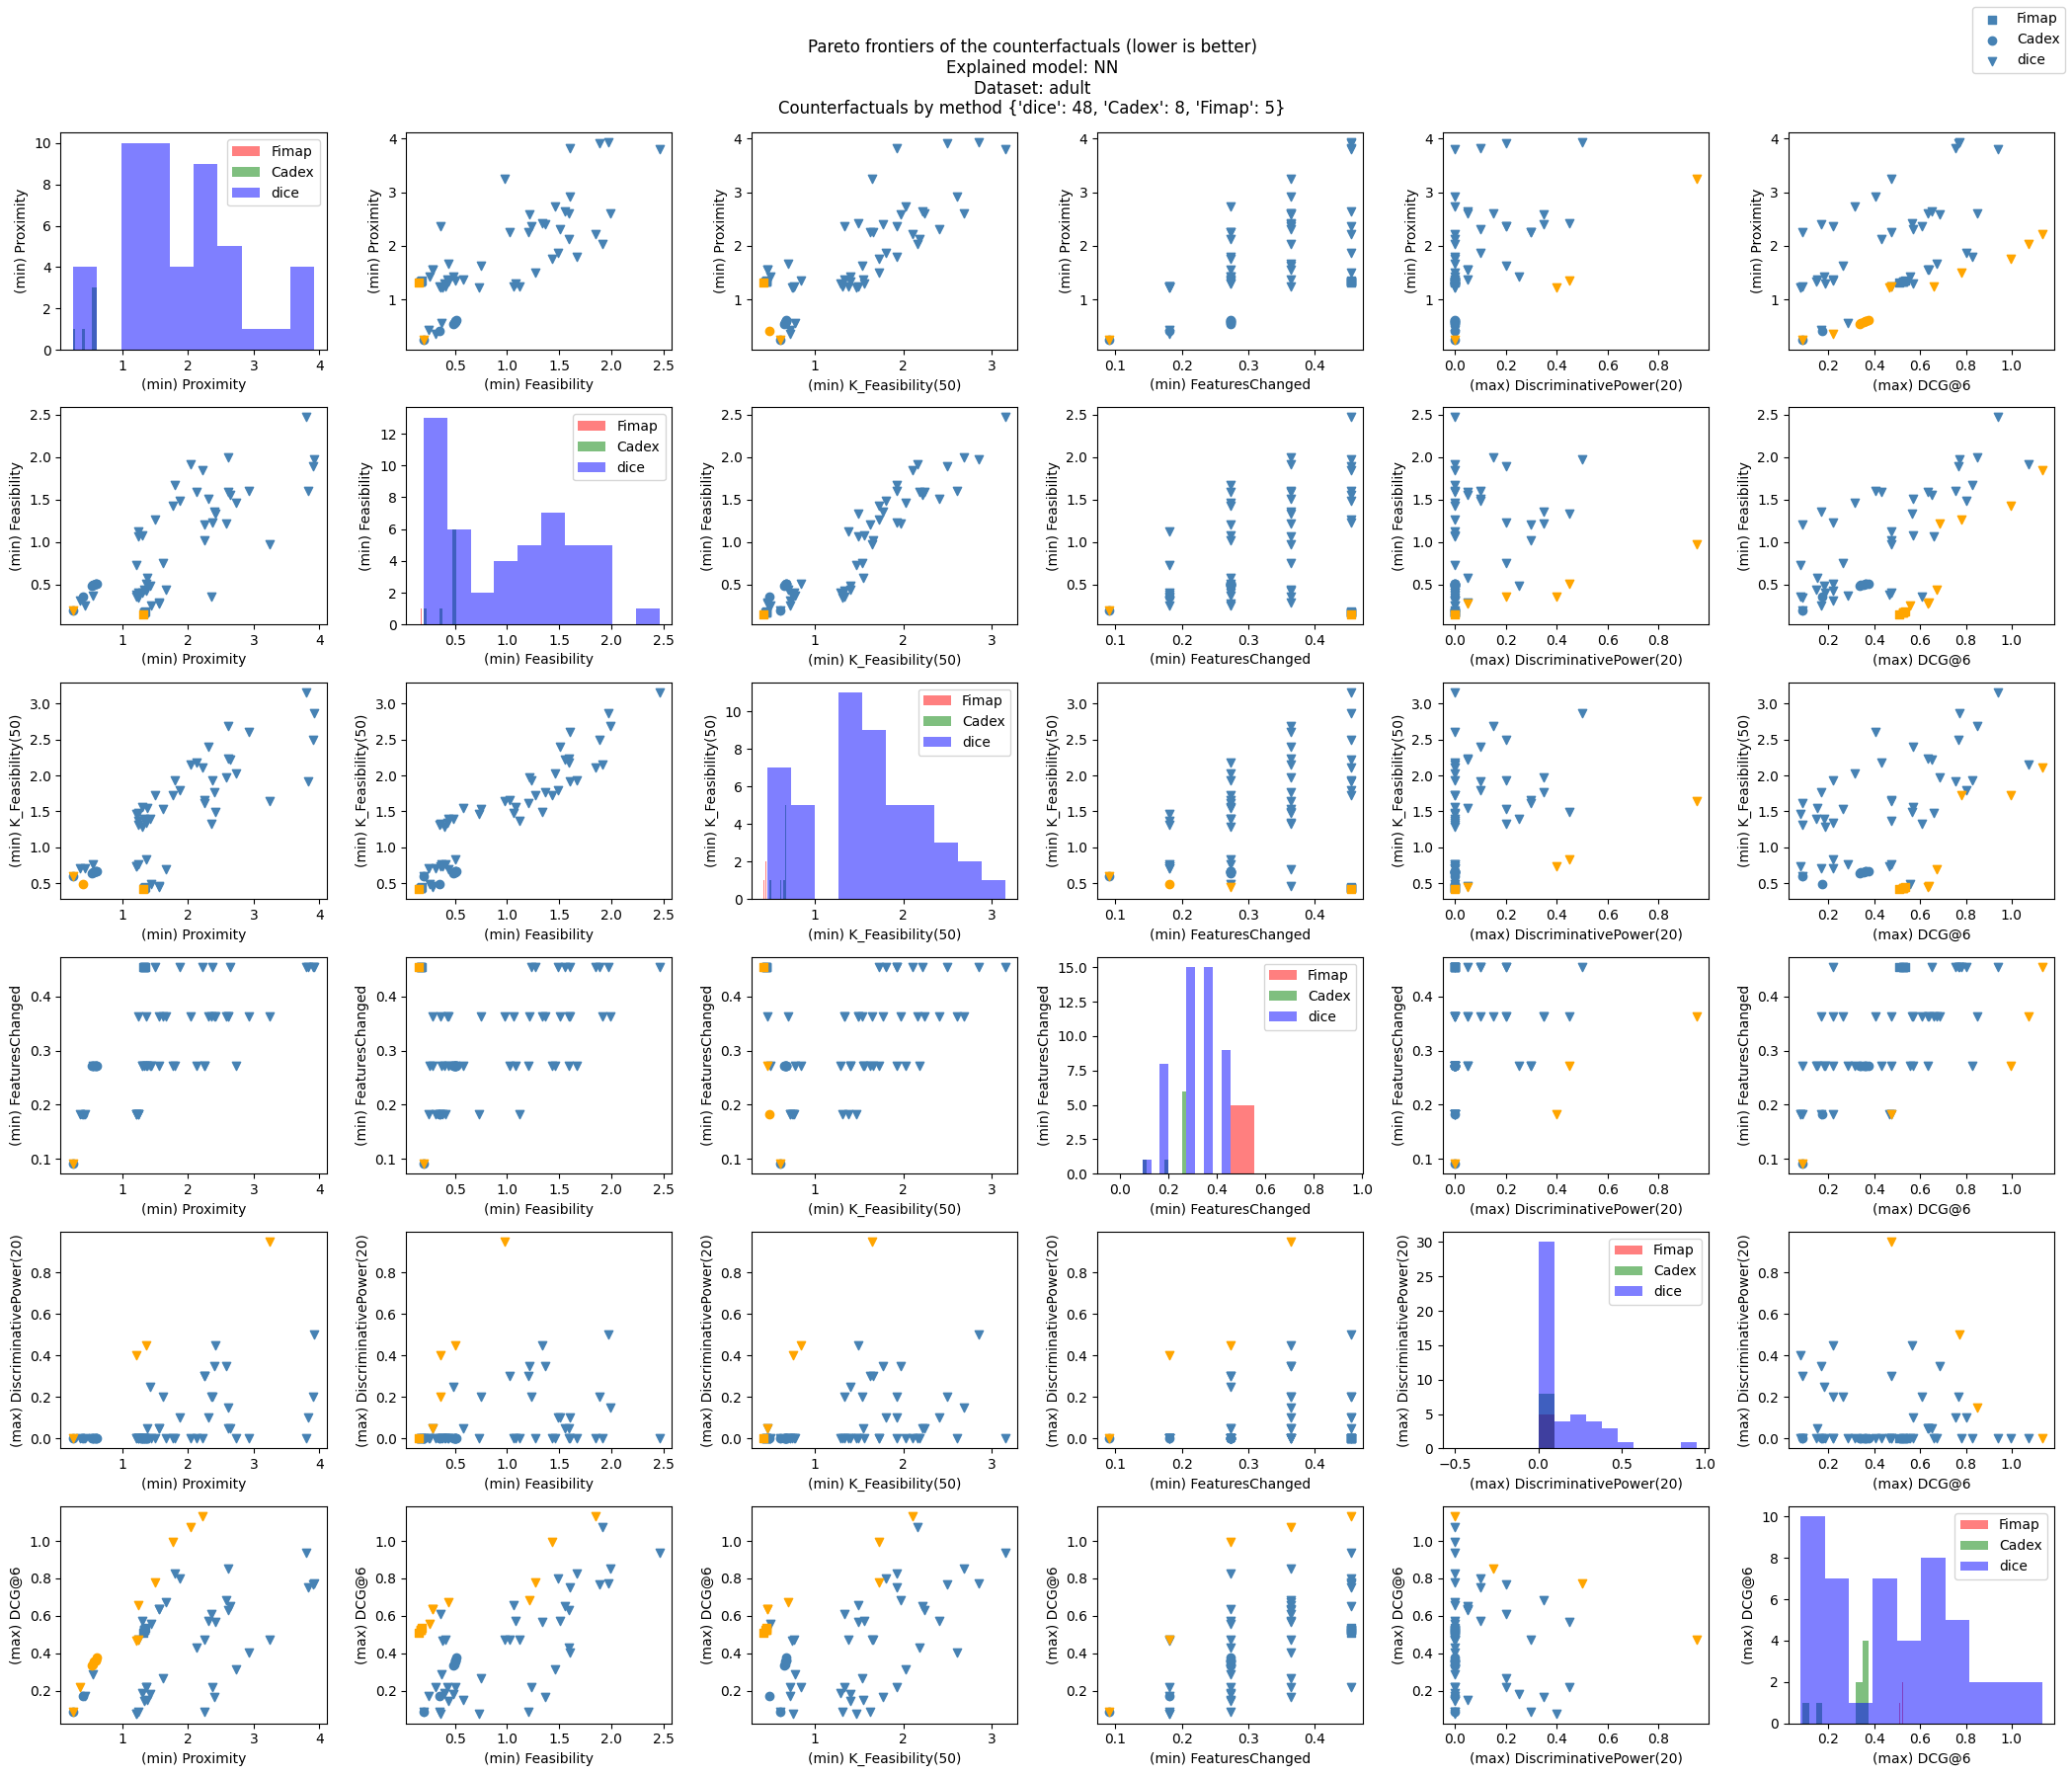

In [54]:
import matplotlib.pyplot as plt
from visualization_helpers import get_pareto_frontier_mask
from pareto import get_pareto_optimal_mask

#metrics_to_plot = ['proximity', 'features_changed', 'feasibility', 'dispreference_dcg', 'non_discriminative_power']
metrics_to_plot = scores_to_plot.drop(['explainer'], axis=1).columns.tolist()

n = len(metrics_to_plot)

fig, ax = plt.subplots(n, n, figsize=(3.5*n, 3*n))

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['s', 'o', 'v', '+', '*', 'p', 'P', 'X', 'D', '>']
labels = []

ax = ax.flatten()

for plot_round in ['nonpareto', 'pareto']:
    for i, other_metric in enumerate(metrics_to_plot):
        for j, metric in enumerate(metrics_to_plot):

            all_x = scores_to_plot[metric].to_numpy()
            all_y = scores_to_plot[other_metric].to_numpy()
            to_check = np.array([all_x, all_y], dtype=np.float64).T

            # Get pareto frontiers mask
            metric_direction = get_optimization_direction(metric)
            other_metric_direction = get_optimization_direction(other_metric)
            optimization_directions = [metric_direction, other_metric_direction]
            all_pareto = get_pareto_optimal_mask(data=to_check, optimization_direction=optimization_directions).astype('bool')



            ax[i*n+j].grid()

            for k, explainer in enumerate(scores_to_plot['explainer'].value_counts().sort_values(ascending=True).index.tolist()):

                mask = scores_to_plot['explainer'] == explainer
                pareto = all_pareto[mask]

                x = scores_to_plot[mask][metric].to_numpy()
                y = scores_to_plot[mask][other_metric].to_numpy()
            
                if plot_round == 'nonpareto':
                    if i == j:
                        ax[i*n+j].hist(x, color=colors[k], label=explainer, alpha=0.5)
                        ax[i*n+j].legend()
                    else:
                        ax[i*n+j].scatter(x[~pareto], y[~pareto], color='steelblue', marker=markers[k], label=explainer)
                elif plot_round == 'pareto' and i!=j:
                    ax[i*n+j].scatter(x[pareto], y[pareto], color='orange', marker=markers[k])

                    if i < j:
                        print(f'For explainer: {explainer} and metrics {metric}, {other_metric}, paretos: {sum(pareto)} out of {len(pareto)}')
                        # print(f'{scores_df[scores_df["explainer"] == explainer][[metric, other_metric]][pareto]}')
            
            ax[i*n+j].set_xlabel(f'({metric_direction}) {metric}')
            ax[i*n+j].set_ylabel(f'({other_metric_direction}) {other_metric}')
    # plt.title('Proximity vs Dispreference DCG \n(Pareto front in orange). \nLower is better.')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

counts = scores_df['explainer'].value_counts()

plt.suptitle(f'Pareto frontiers of the counterfactuals (lower is better)\nExplained model: {explained_model_name}\nDataset: {dataset_name}\nCounterfactuals by method {counts.to_dict()}\n')
plt.tight_layout()
plt.savefig(f'../images/{dataset_name}/{explained_model_name}/{dataset_name}_{explained_model_name}_{instance_to_explain_index}_pairplot_with_frontiers.png')
plt.show()

In [55]:
scores_to_plot.to_csv(f'cf_scores_tmp-{explained_model_name}-{dataset_name}-{instance_to_explain_index}.csv', index=False)

In [56]:
# scores_df[['feasibility', 'features_changed']]

In [57]:
# metric = 'feasibility'
# other_metric = 'features_changed'
# all_x = scores_df[metric].to_numpy()
# all_y = scores_df[other_metric].to_numpy()
# to_check = np.array([all_x, all_y], dtype=np.float64).T
# all_pareto = get_pareto_frontier_mask(to_check)
# scores_df[[metric, other_metric, 'explainer']][all_pareto]

In [58]:
# scores_df['explainer']

3D plot

In [59]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')


# metric = 'Proximity'
# other_metric = 'Features Changed (normalized)'
# other_other_metric = 'Feasibility'

# all_x = scores_to_plot[metric].to_numpy()
# all_y = scores_to_plot[other_metric].to_numpy()
# all_z = scores_to_plot[other_other_metric].to_numpy()
# to_check = np.array([all_x, all_y, all_z], dtype=np.float64).T

# # Get pareto frontiers mask
# metric_direction = get_optimization_direction(metric)
# other_metric_direction = get_optimization_direction(other_metric)
# other_other_metric_direction = get_optimization_direction(other_other_metric)
# optimization_directions = [metric_direction, other_metric_direction, other_other_metric_direction]
# all_pareto = get_pareto_optimal_mask(data=to_check, optimization_direction=optimization_directions).astype('bool')

# for plot_round in ['nonpareto', 'pareto']:
#     for k, explainer in enumerate(scores_to_plot['explainer'].value_counts().sort_values(ascending=True).index.tolist()):

#         mask = scores_to_plot['explainer'] == explainer
#         pareto = all_pareto[mask]

#         x = scores_to_plot[mask][metric].to_numpy()
#         y = scores_to_plot[mask][other_metric].to_numpy()
#         z = scores_to_plot[mask][other_other_metric].to_numpy()

#         if plot_round == 'nonpareto':
#             ax.scatter(x[~pareto], y[~pareto], z[~pareto], color='steelblue', marker=markers[k], label=explainer)
#         elif plot_round == 'pareto':
#             ax.scatter(x[pareto], y[pareto], z[pareto], color='orange', marker=markers[k])
         
# ax.set_xlabel(f'({metric_direction}) {metric}')
# ax.set_ylabel(f'({other_metric_direction}) {other_metric}')
# ax.set_zlabel(f'({other_other_metric_direction}) {other_other_metric}')

# plt.title(f'Pareto frontiers of the counterfactuals (lower is better)\nExplained model: {explained_model_name}\nDataset: {dataset_name}\nCounterfactuals by method {counts.to_dict()}\n')

# plt.tight_layout()
# plt.legend()
# plt.show()